# Optimization

The following will demonstrate four methods of linear regression optimization:

1. Gradient Descent
2. Gradient Descent with Momentum
3. RMSprop
4. Adam

For each of the examples, a linear model `f(x)=w*x+b` will be fit to a set of data points.  

## Gradient Descent

The general idea is that the weight `w` and bias `b` will be updated by moving in the direction of lower cost `J`.  To move in the direction of lower cost, the model must change the parameters in a direction opposite of the slope:

$$
\begin{align}\Delta w = -\frac{\delta J}{\delta w}\\
\Delta b = -\frac{\delta J}{\delta b}
\end{align}
$$

We'll use the mean squared error as the cost function:

$$
J = \frac{1}{2n}\sum_{i=1}^{n}(f(x^{(i)}-y^{(i)})^2 = \frac{1}{2n}\sum_{i=1}^{n}((w*x^{(i)}+b)-y^{(i)})^2
$$

For simplicity, we will do stochastic gradient descent, where one data point will be used at a time, setting `n=1`:

$$
J = \frac{1}{2}((w*x+b)-y)^2
$$

This gives us the relationships

$$
\begin{align}\frac{\delta J}{\delta w} = ((w*x+b)-y) * w = J*w\\
\frac{\delta J}{\delta b} = ((w*x+b)-y) = J
\end{align}
$$

### Learning Rate

A learning rate $\alpha$ is included to tune how fast the mdoel will update the parameters.  

$$
\begin{align}\Delta w = -\alpha\frac{\delta J}{\delta w}\\
\Delta b = -\alpha\frac{\delta J}{\delta b}
\end{align}
$$


If the learning rate is too slow, the model will take a long time to converge.  If it's too high, it can diverge.


## TensorFlow Example

The following code will set up a graph where `w` and `b` are variables that will be updated by our gradient descent optimizer.  The placeholders `data` and `label` are used to feed the input data `x` and the labels `y` into the graph during training.  The data will be generated using parameters `w_real` and `b_real` with some added noise, and the parameters for the model fit will be initialized by `w_init` and `b_init`.  

The variables `w_expected` and `b_expected` will be used for gradient checking to see that we can predict how TensorFlow will update `w` and `b`.

*Note:* Tensorflow does not include the `1/2` factor in the loss function, so the update to `w_expected` and `b_expected` needs to be doubled.

In [1]:
import tensorflow as tf
import numpy as np
lr = 0.1      # Learning rate
w_real = 1.2 # Real w
w_init = -1.5 # Initialize w
b_real = .5 # Real b
b_init = 1.5 # Initialize b

# Variables
w = tf.Variable(w_init, name='W', dtype=tf.float32)
b = tf.Variable(b_init, name='B', dtype=tf.float32)
data = tf.placeholder(tf.float32)
label = tf.placeholder(tf.float32)
w_expected = w_init
b_expected = b_init

# Layers
prediction = tf.add(tf.multiply(w,data),b)
loss = tf.losses.mean_squared_error(predictions=prediction,labels=label)

# Optimizer
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

print('W Exp.\tActual\tB Exp.\tActual')

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in range(10):
        # Get new point for training
        x = np.random.uniform(0,1)
        y = (w_real*x + b_real + np.random.normal(0,.02))
        pred = w_expected*x+b_expected
        w_expected -= lr*2*(pred-y)*x
        b_expected -= lr*2*(pred-y)

        # Train
        sess.run(train, feed_dict={data:x, label:y})
        
        # Get the actual updated weight
        w_current,b_current = sess.run([w,b])
        
        # Print comparison of calculated and actual updated weights
        print("{:0.3f}\t{:0.3f}\t{:0.3f}\t{:0.3f}".format(w_expected, w_current, b_expected, b_current))

W Exp.	Actual	B Exp.	Actual
-1.504	-1.504	1.489	1.489
-1.521	-1.521	1.410	1.410
-1.537	-1.537	1.311	1.311
-1.496	-1.496	1.400	1.400
-1.508	-1.508	1.265	1.265
-1.375	-1.375	1.466	1.466
-1.247	-1.247	1.644	1.644
-1.270	-1.270	1.473	1.473
-1.276	-1.276	1.454	1.454
-1.286	-1.286	1.297	1.297


As can be seen, the model updates `w` and `b` as expected based on our equations.

### Viewing the Updates

The following can be used to actually view the model fit as it changes.

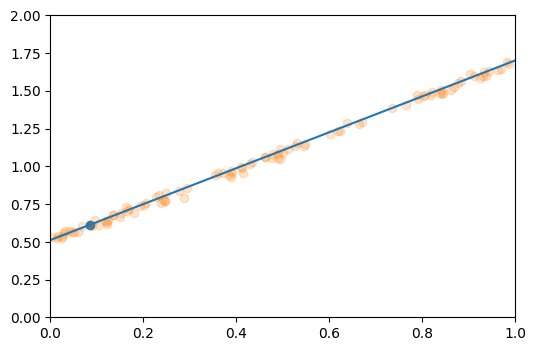

In [2]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

lr = 0.4 # Learning rate
w_real = 1.2 # Real w
w_init = -1.5 # Initialize w
b_real = .5 # Real b
b_init = 1.5 # Initialize b

# Variables
w = tf.Variable(w_init, dtype=tf.float32)
b = tf.Variable(b_init, dtype=tf.float32)
data = tf.placeholder(tf.float32)
label = tf.placeholder(tf.float32)

# Layers
prediction = tf.add(tf.multiply(w,data),b)
loss = tf.losses.mean_squared_error(predictions=prediction,labels=label)

# Optimizer
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

x_set = []
y_set = []
w_set = [w_init]
b_set = [b_init]

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in range(100):
        # Get new point for training
        x = np.random.uniform(0,1)
        y = w_real*x + b_real + np.random.normal(0,.02)
    
        # Train
        sess.run(train, feed_dict={data:x, label:y})
        
        # Get the actual updated weight
        w_new,b_new = sess.run([w,b])
        w_set.append(w_new)
        b_set.append(b_new)     

        fig, ax = plt.subplots(dpi=100)
        ax.scatter(x, y)
        ax.scatter(x_set,y_set,alpha=0.2)
        x_set.append(x)
        y_set.append(y)
        
        ax.plot([x,x],[y,w_new*x+b_new],c='r')
        ax.plot([0,2],[b_new,2*w_new+b_new])
        plt.ylim([0,2])
        plt.xlim([0,1])
        display.clear_output(wait=True)
        display.display(fig)
        plt.close()


We can also create a data set and use it to view the cost function surface, showing the cost for different values of `w` and `b`.  Then we can use this 2D cost surface to see how the optimizer changes `w` and `b` on this plane. Yellow regions are of higher cost, blue is lower cost, and the red dot is the position of `w_real` and `b_real`. 

In [3]:
step_size = 0.05
wrange = [-2,2.5]
brange = [-1.2,2.8]
wsize = int((wrange[1]-wrange[0])/step_size)
bsize = int((brange[1]-brange[0])/step_size)
wset = np.arange(wrange[0],wrange[1],step_size)
bset = np.arange(brange[0],brange[1],step_size)

mse = np.zeros((bsize,wsize))
x = np.random.uniform(0,1,200)
y = w_real*x + b_real + np.random.normal(0,.02,200)
for i,w in enumerate(wset):
    for j,b in enumerate(bset):
        mse[bsize-1-j,i] = np.square(y-(w*x+b)).sum()


Text(0,0.5,'b')

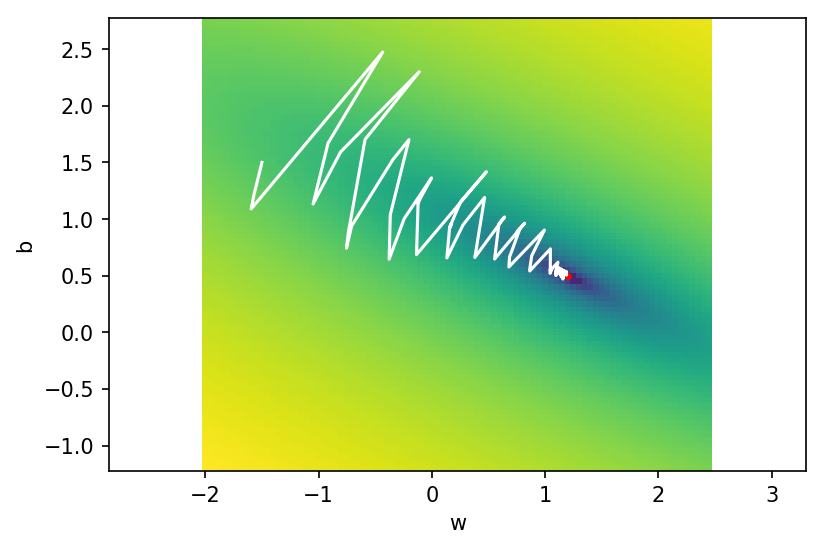

In [4]:
plt.figure(dpi=150)
plt.imshow(np.log(mse), extent=[wrange[0]-step_size/2.,wrange[1]-step_size/2.,
                                brange[0]-step_size/2.,brange[1]-step_size/2.])
plt.plot(np.array(w_set), np.array(b_set),c='white')
plt.scatter([w_real],[b_real],c='r',s=5)
plt.axis('equal')
plt.xlabel('w')
plt.ylabel('b')

As seen, gradient descent is susceptible to large changes that may not be in the right direction.  It can move lateral to the direction of the best fit and bounce back and forth.  It can also get stuck in areas of local minima.  The following improve the performance of gradient descent.


# Gradient Descent with Momentum

Momentum behaves just the same as a real-live moving object.  A step doesn't just depend on the current loss (slope), but also how it has been changing previously.  It behaves more like a ball rolling on the cost surface.  This can help remove the lateral jumps and also move past local minima.

The weights are updated based on the relationship

$$
\Delta w = -\alpha v_{dw}
$$

where $v_{dw}$ is the exponentially weighted average (acting similar to the velocity of a moving object) which is calculated by

$$
v_{dw} = \beta v_{dw} + (1-\beta) dw
$$

When the momentum hyperparameter $\beta$ is larger, it gives more importance to the historic changes than the current $dw$.  A similar function is used for $\Delta b$ and $v_{db}$.

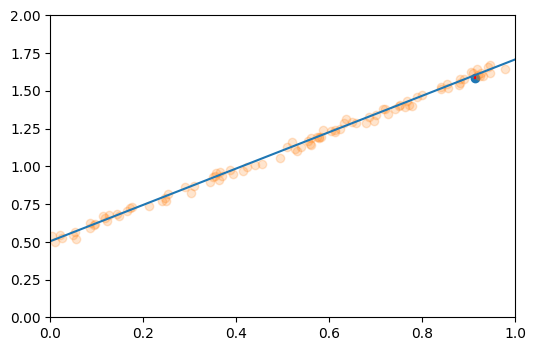

In [5]:
lr = 0.05 # Learning rate
w_real = 1.2 # Real w
w_init = -1.5 # Initialize w
b_real = .5 # Real b
b_init = 1.5 # Initialize b

# Variables
w = tf.Variable(w_init, dtype=tf.float32)
b = tf.Variable(b_init, dtype=tf.float32)
data = tf.placeholder(tf.float32)
label = tf.placeholder(tf.float32)

# Layers
prediction = tf.add(tf.multiply(w,data),b)
loss = tf.losses.mean_squared_error(predictions=prediction,labels=label)

# Optimizer
optimizer = tf.train.MomentumOptimizer(lr, momentum=0.9)
train = optimizer.minimize(loss)

x_set = []
y_set = []
w_set = [w_init]
b_set = [b_init]

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in range(100):
        # Get new point for training
        x = np.random.uniform(0,1)
        y = w_real*x + b_real + np.random.normal(0,.02)
    
        # Train
        sess.run(train, feed_dict={data:x, label:y})
        
        # Get the actual updated weight
        w_new,b_new = sess.run([w,b])
        w_set.append(w_new)
        b_set.append(b_new)     

        fig, ax = plt.subplots(dpi=100)
        ax.scatter(x, y)
        ax.scatter(x_set,y_set,alpha=0.2)
        x_set.append(x)
        y_set.append(y)
        
        ax.plot([x,x],[y,w_new*x+b_new],c='r')
        ax.plot([0,2],[b_new,2*w_new+b_new])
        plt.ylim([0,2])
        plt.xlim([0,1])
        display.clear_output(wait=True)
        display.display(fig)
        plt.close()


Text(0,0.5,'b')

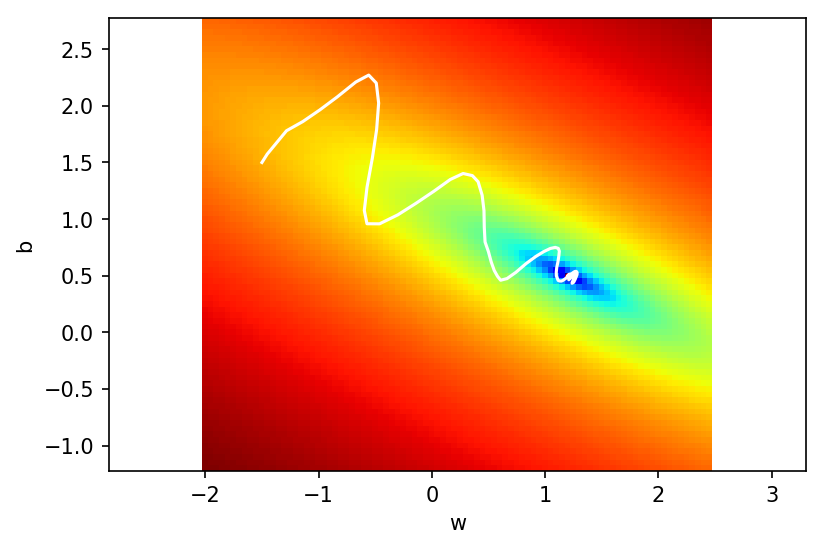

In [6]:
plt.figure(dpi=150)
plt.imshow(np.log(mse), extent=[wrange[0]-step_size/2.,wrange[1]-step_size/2.,
                                brange[0]-step_size/2.,brange[1]-step_size/2.],cmap='jet')
plt.plot(np.array(w_set), np.array(b_set),c='white')
plt.scatter([w_real],[b_real],c='r',s=5)
plt.axis('equal')
plt.xlabel('w')
plt.ylabel('b')

Rather than sharp jumps, the parameters change smoothly.

# RMSprop

RMSprop aims to dampen the lateral changes by giving smaller weighting to large values of $dw$.  

$$
\begin{align}\Delta w = -\alpha \frac{dw}{\sqrt{S_{dw}}}\\
S_{dw} = \beta S_{dw} + (1-\beta) dw^2
\end{align}
$$

Notice that the function for $S_{db}$ is similar $v_{db}$, except it's proportional to $db^2$ instead. The idea is that when $db$ is consistently large, it could be that it's jumping back and forth.  The variable $S_{db}$ gets large to decrease $\Delta w$ and make smaller steps.

Similar functions are used for $\Delta b$ and $S_{db}$.  The default value for $\beta$ is 0.9.

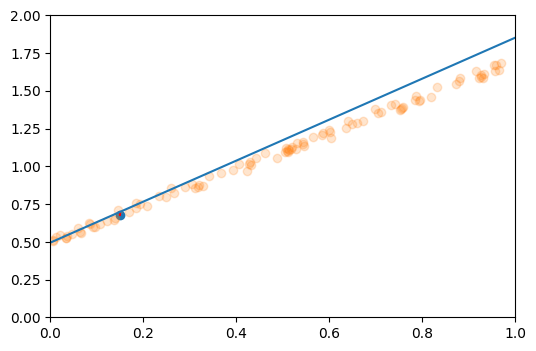

In [7]:
lr = 0.2 # Learning rate
w_real = 1.2 # Real w
w_init = -1.5 # Initialize w
b_real = .5 # Real b
b_init = 1.5 # Initialize b

# Variables
w = tf.Variable(w_init, dtype=tf.float32)
b = tf.Variable(b_init, dtype=tf.float32)
data = tf.placeholder(tf.float32)
label = tf.placeholder(tf.float32)

# Layers
prediction = tf.add(tf.multiply(w,data),b)
loss = tf.losses.mean_squared_error(predictions=prediction,labels=label)

# Optimizer
optimizer = tf.train.RMSPropOptimizer(lr)
train = optimizer.minimize(loss)

#print('W Exp.\tActual\tB Exp.\tActual')
x_set = []
y_set = []
w_set = [w_init]
b_set = [b_init]

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in range(100):
        # Get new point for training
        x = np.random.uniform(0,1)
        y = w_real*x + b_real + np.random.normal(0,.02)
    
        # Train
        sess.run(train, feed_dict={data:x, label:y})
        
        # Get the actual updated weight
        w_new,b_new = sess.run([w,b])
        w_set.append(w_new)
        b_set.append(b_new)     

        fig, ax = plt.subplots(dpi=100)
        ax.scatter(x, y)
        ax.scatter(x_set,y_set,alpha=0.2)
        x_set.append(x)
        y_set.append(y)
        
        ax.plot([x,x],[y,w_new*x+b_new],c='r')
        ax.plot([0,2],[b_new,2*w_new+b_new])
        plt.ylim([0,2])
        plt.xlim([0,1])
        display.clear_output(wait=True)
        display.display(fig)
        plt.close()


Text(0,0.5,'b')

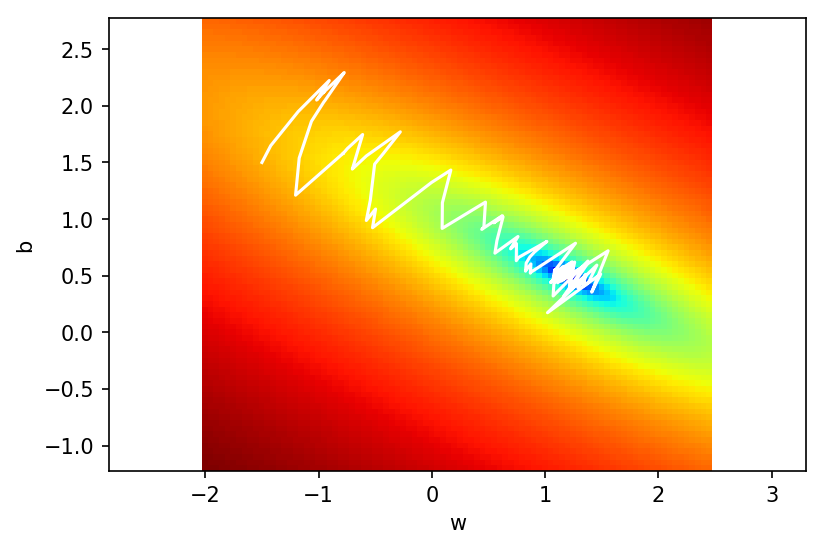

In [8]:
plt.figure(dpi=150)
plt.imshow(np.log(mse), extent=[wrange[0]-step_size/2.,wrange[1]-step_size/2.,
                                brange[0]-step_size/2.,brange[1]-step_size/2.],cmap='jet')
plt.plot(np.array(w_set), np.array(b_set),c='white')
plt.scatter([w_real],[b_real],c='r',s=5)
plt.axis('equal')
plt.xlabel('w')
plt.ylabel('b')

# Adam

Adam (Adaptive moment estimation) is a combination of momentum and RMSprop.  First, different $\beta$ values are used for the two updating terms:

$$
\begin{align}v_{dw} = \beta_1 v_{dw} + (1-\beta_1)dw\\
S_{dw} = \beta_2 S_{dw} + (1-\beta_2)dw
\end{align}
$$

Adam also uses a bias correction that uses the update iteration $t$:

$$
\begin{align}v_{dw}^{corrected} = \frac{v_{dw}}{(1-\beta_1^t)}\\
S_{dw}^{corrected} = \frac{S_{dw}}{(1-\beta_2^t)}
\end{align}
$$

Finally, a small value $\epsilon$ is added so as not to be dividing by zero when $S_{dw}=0$.  The final function for $\Delta w$ is

$$
\Delta w = - \alpha \frac{v_{dw}^{corrected}}{\sqrt{S_{dw}^{corrected}}+\epsilon}
$$

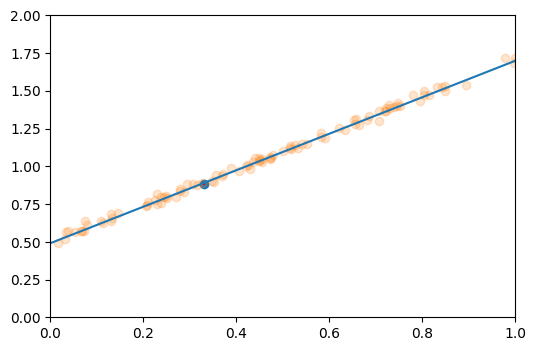

In [9]:
lr = 0.2 # Learning rate
w_real = 1.2 # Real w
w_init = -1.5 # Initialize w
b_real = .5 # Real b
b_init = 1.5 # Initialize b

# Variables
w = tf.Variable(w_init, dtype=tf.float32)
b = tf.Variable(b_init, dtype=tf.float32)
data = tf.placeholder(tf.float32)
label = tf.placeholder(tf.float32)

# Layers
prediction = tf.add(tf.multiply(w,data),b)
loss = tf.losses.mean_squared_error(predictions=prediction,labels=label)

# Optimizer
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

#print('W Exp.\tActual\tB Exp.\tActual')
x_set = []
y_set = []
w_set = [w_init]
b_set = [b_init]

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in range(100):
        # Get new point for training
        x = np.random.uniform(0,1)
        y = w_real*x + b_real + np.random.normal(0,.02)
    
        # Train
        sess.run(train, feed_dict={data:x, label:y})
        
        # Get the actual updated weight
        w_new,b_new = sess.run([w,b])
        w_set.append(w_new)
        b_set.append(b_new)     

        fig, ax = plt.subplots(dpi=100)
        ax.scatter(x, y)
        ax.scatter(x_set,y_set,alpha=0.2)
        x_set.append(x)
        y_set.append(y)
        
        ax.plot([x,x],[y,w_new*x+b_new],c='r')
        ax.plot([0,2],[b_new,2*w_new+b_new])
        plt.ylim([0,2])
        plt.xlim([0,1])
        display.clear_output(wait=True)
        display.display(fig)
        plt.close()


Text(0,0.5,'b')

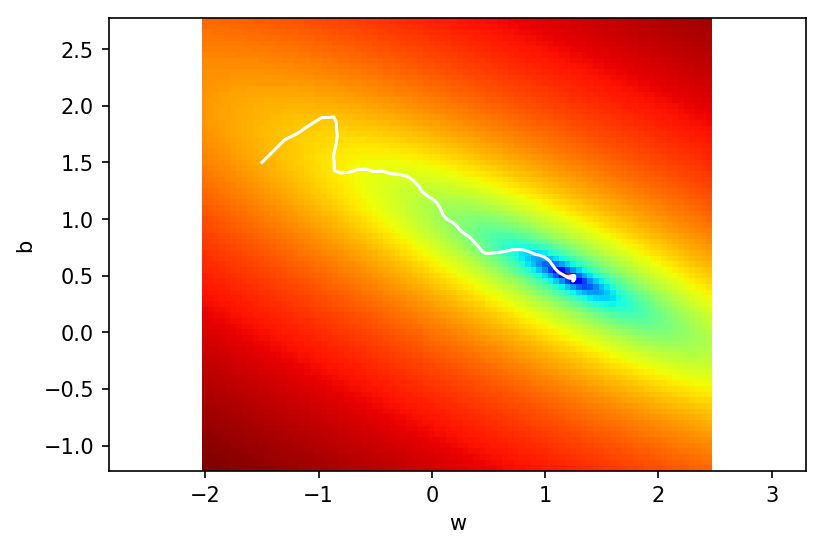

In [11]:
plt.figure(dpi=150)
plt.imshow(np.log(mse), extent=[wrange[0]-step_size/2.,wrange[1]-step_size/2.,
                                brange[0]-step_size/2.,brange[1]-step_size/2.],cmap='jet')
plt.plot(np.array(w_set), np.array(b_set),c='white')
plt.scatter([w_real],[b_real],c='r',s=5)
plt.axis('equal')
plt.xlabel('w')
plt.ylabel('b')

As can be seen, Adam results in smooth changes with the lateral motion dampened.